In [78]:
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformation
import data_filter as dafi
import estimate_height as esth

from scipy import signal

WAVELENTH_S1 = 0.1905 # meter


In [79]:
# setting 1004 on the corner Esslingen
main_path = os.path.abspath('../data/20221004/2/')
time_split_length = 1800
azimut_mask = [300,330]
elevation_mask = [0,25]

In [80]:
data_dict = dafi.generate_dataframe(main_path)
satellite_list = data_dict.keys()
for satellite_code in satellite_list:
    data_dict[satellite_code] = dafi.azimut_filter(data_dict[satellite_code],azimut_mask)
    data_dict[satellite_code] = dafi.elevation_filter(data_dict[satellite_code],elevation_mask)

In [81]:
satellite_list

dict_keys(['G01', 'G03', 'G04', 'G08', 'G17', 'G21', 'G22', 'G32', 'G19', 'G31', 'R06', 'R07', 'R08', 'R21', 'R23', 'E07', 'E08', 'E26', 'E33', 'E12', 'E19', 'R24', 'G09', 'R01', 'G06', 'E10', 'R09', 'R10', 'R17', 'G11'])

In [82]:
satellite_code = 'G06'
dataframe = data_dict[satellite_code]
print(dataframe)

                          time   azimut  elevation   snr1   snr2
0    2022-10-04 09:03:40+00:00  305.395      0.002    NaN    NaN
1    2022-10-04 09:03:41+00:00  305.397      0.008    NaN    NaN
2    2022-10-04 09:03:42+00:00  305.400      0.014    NaN    NaN
3    2022-10-04 09:03:43+00:00  305.403      0.020    NaN    NaN
4    2022-10-04 09:03:44+00:00  305.405      0.026    NaN    NaN
...                        ...      ...        ...    ...    ...
3839 2022-10-04 10:07:39+00:00  310.877     24.972  44.50  44.10
3840 2022-10-04 10:07:40+00:00  310.877     24.979  44.40  44.85
3841 2022-10-04 10:07:41+00:00  310.877     24.986  44.55  44.40
3842 2022-10-04 10:07:42+00:00  310.877     24.992  44.70  44.60
3843 2022-10-04 10:07:43+00:00  310.876     24.999  44.65  44.65

[3844 rows x 5 columns]


In [83]:
dataframe = dataframe.iloc[0:-1][:]
dataframe

,time,azimut,elevation,snr1,snr2
0,2022-10-04 09:03:40+00:00,305.395,0.002,NaN,NaN
1,2022-10-04 09:03:41+00:00,305.397,0.008,NaN,NaN
2,2022-10-04 09:03:42+00:00,305.400,0.014,NaN,NaN
3,2022-10-04 09:03:43+00:00,305.403,0.020,NaN,NaN
4,2022-10-04 09:03:44+00:00,305.405,0.026,NaN,NaN
...,...,...,...,...,...
3838,2022-10-04 10:07:38+00:00,310.877,24.965,44.25,43.85
3839,2022-10-04 10:07:39+00:00,310.877,24.972,44.50,44.10
3840,2022-10-04 10:07:40+00:00,310.877,24.979,44.40,44.85
3841,2022-10-04 10:07:41+00:00,310.877,24.986,44.55,44.40


In [84]:
dataframe_sort = dataframe.sort_values(by='elevation')
snr1_db = np.array(dataframe_sort['snr1'])

In [85]:
elevation_sort = np.array(dataframe_sort['elevation'])
non_nan_index = ~np.isnan(snr1_db)

elevation_filtered = elevation_sort[non_nan_index]
elevation_filtered = elevation_filtered.reshape(elevation_filtered.size,1)
snr1_volt_filtered = snr1_db[non_nan_index]
snr1_volt_filtered = snr1_volt_filtered.reshape(snr1_volt_filtered.size,1)

design_matrix = np.concatenate((elevation_filtered**2,elevation_filtered,np.ones((elevation_filtered.size,1))),axis=1)


Text(0, 0.5, 'snr(db)')

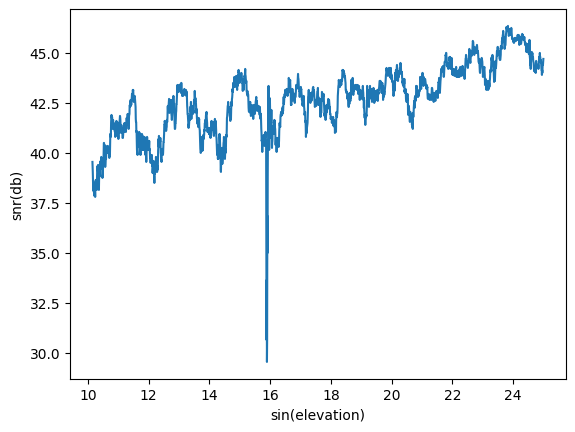

In [86]:
plt.plot(elevation_filtered,snr1_volt_filtered)
plt.xlabel('sin(elevation)')
plt.ylabel('snr(db)')

In [87]:
para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),design_matrix.T),snr1_volt_filtered)
print(para)

[[5.63629532e-03]
 [1.22868320e-01]
 [3.86420418e+01]]


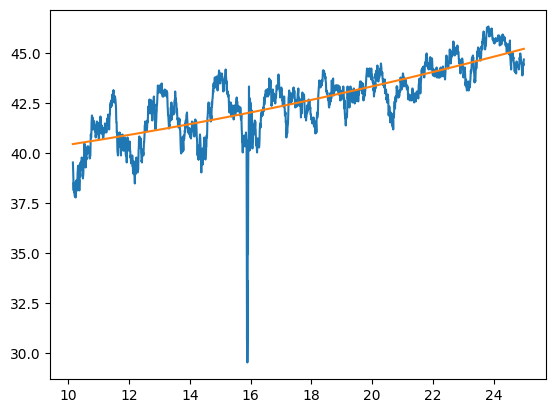

In [88]:

snr1_ref = snr1_volt_filtered - (elevation_filtered**2 * para[0,0] + para[1,0]*elevation_filtered + para[2,0])
plt.plot(elevation_filtered,snr1_volt_filtered)
plt.plot(elevation_filtered,(elevation_filtered**2 * para[0,0] + para[1,0]*elevation_filtered + para[2,0]))


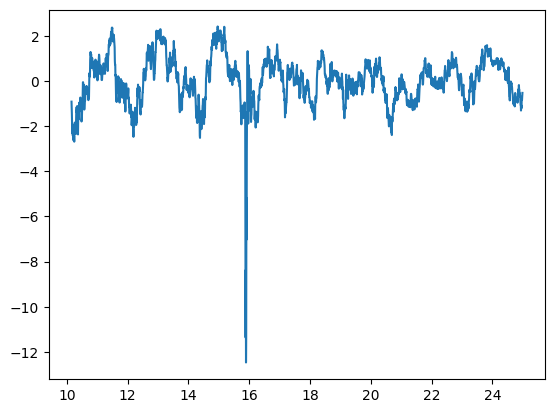

In [89]:
plt.plot(elevation_filtered,snr1_ref)

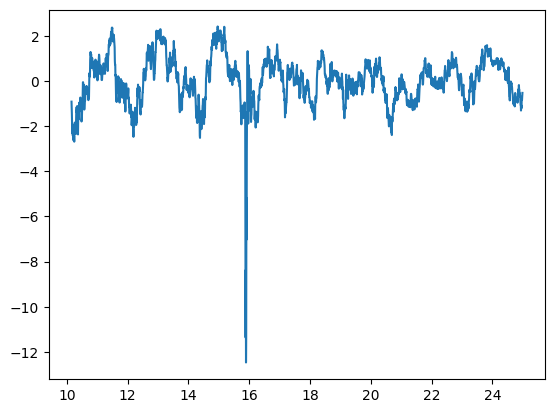

In [90]:
elevation_filtered_choosen = elevation_filtered
snr1_ref_choosen = snr1_ref
plt.plot(elevation_filtered_choosen,snr1_ref_choosen)


[ 0.52988299  1.07917792  1.48915892  1.90113011  2.66934693  3.16490649
  4.00875088  4.57794779  5.1769977   5.68250825  6.14821482  6.65571557
  7.18709871  7.54135414  8.26379638  8.80911091  9.59324932 10.15249525
 10.72368237 11.57150715 12.0750275  12.97857786 14.04134413 14.9269827
 16.04348435 17.18983898 17.9719872  18.9790279  19.51240124]
2.6693469346934693


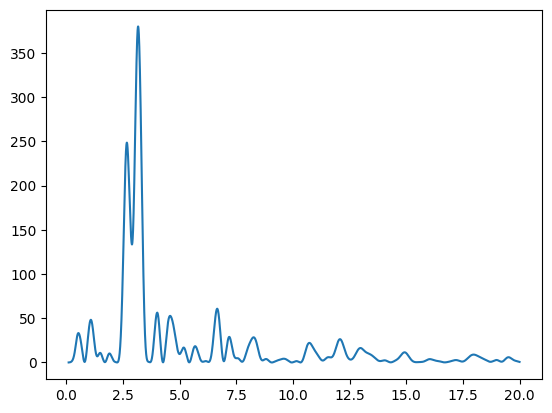

In [91]:
x_data = (np.sin(elevation_filtered_choosen*np.pi/180) * 4 * np.pi / WAVELENTH_S1).ravel()
y_data = snr1_ref_choosen.ravel()
w1 = np.linspace(0.1,20,10000)
power1 = signal.lombscargle(x_data,y_data,w1,normalize=True)
power1 = signal.lombscargle(x_data,y_data,w1)
plt.plot(w1,power1)


peaks,_= signal.find_peaks(power1)
#plt.plot(w[peaks],power[peaks])
peaks_power = power1[peaks]

h = w1[peaks]
print(h)
#h = h[peaks_power==max(peaks_power)] # the max
h = h[4] # the second max
print(h)


[0.22575706]
[-0.76048922]


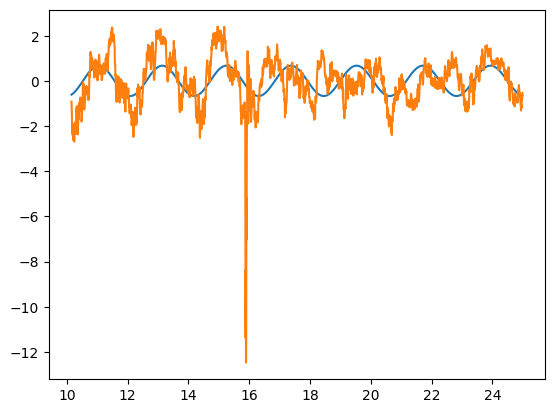

In [92]:
# generates a ideal signal
A_Matrix = np.concatenate([np.sin(4*h*np.pi*np.sin(elevation_filtered_choosen/180*np.pi)/WAVELENTH_S1),np.cos(4*h*np.pi*np.sin(elevation_filtered_choosen/180*np.pi)/WAVELENTH_S1)],axis=1)
param = np.dot(np.linalg.solve(np.dot(A_Matrix.T,A_Matrix),A_Matrix.T),snr1_ref_choosen)
signal_simu = np.dot(A_Matrix,param)

amplitude = np.sqrt(param[0]**2 * param[1]**2)
print(amplitude)

phi = np.arctan2(param[1],param[0])
print(phi)

plt.plot(elevation_filtered_choosen,signal_simu)
plt.plot(elevation_filtered_choosen,snr1_ref_choosen)

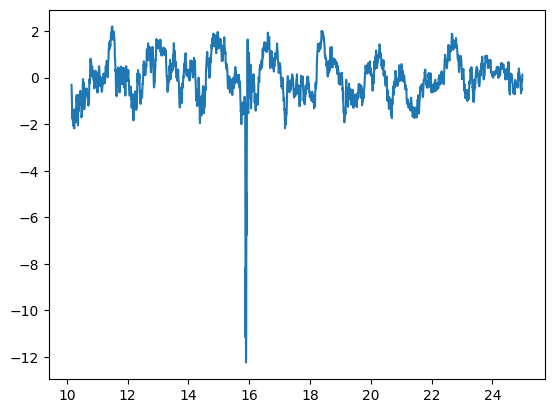

In [93]:
plt.plot(elevation_filtered_choosen,snr1_ref_choosen-signal_simu)

[3.11515152]


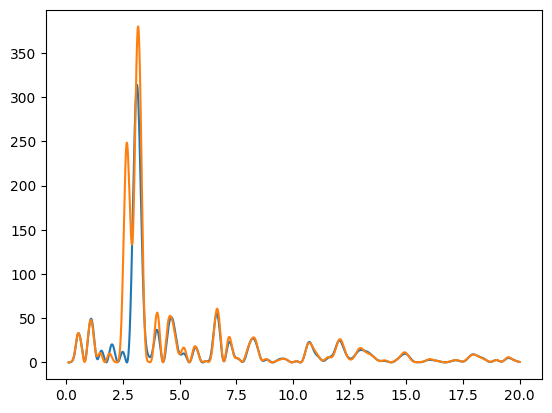

In [94]:
x_data = (np.sin(elevation_filtered_choosen*np.pi/180) * 4 * np.pi / WAVELENTH_S1).ravel()
y_data = (snr1_ref_choosen-signal_simu).ravel()
w2 = np.linspace(0.1,20,10000)
power2 = signal.lombscargle(x_data,y_data,w2,normalize=True)
power2 = signal.lombscargle(x_data,y_data,w2)
plt.plot(w2,power2)
peaks,_= signal.find_peaks(power2)
#plt.plot(w[peaks],power[peaks])
peaks_power = power2[peaks]

h = w2[peaks]
h = h[peaks_power==max(peaks_power)]
print(h)
plt.plot(w1,power1)
# before 2.66
# after 2.74

# befoe 3.16
# after 3.11

[nan, nan, nan, 2.7019999999998126, 3.3309999999997433, 2.5399999999998304]


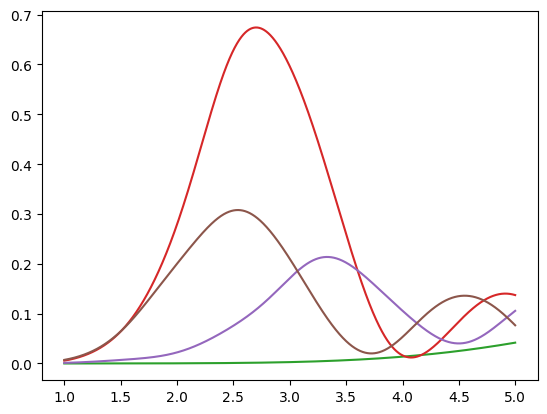

In [100]:
time_length = 10 # minutes
time_list, height_list, azimut_list, frequency_list,power_list= esth.split_result(dataframe,time_length,min_height=1,max_height=4)
print(height_list)

for i,_ in enumerate(frequency_list):
    plt.plot(frequency_list[i],power_list[i])


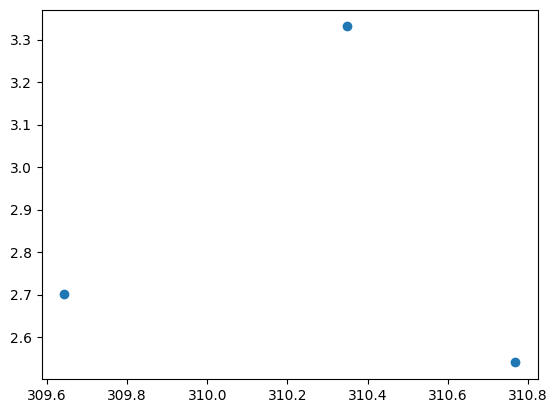

In [101]:
plt.scatter(azimut_list,height_list)